# How To Predict Hotel Booking Cancellation to Minimize Hotel's Financial Loss

## Background
In accommodation business, it is common for guests to cancel their booking, and some guests might cancel just before their expected check-in time. In a scenario where a hotel is fully booked, business owner might wait for the expected guest to come, and reject any other customer looking for a place to stay. This situation poses a risk that could cause financial loss if the guest called and canceled their booking, or didn't even come, and the room can't be sold anymore for that day.

What if we can predict if a guest will likely cancel their booking before their expected check-in time? If we can predict that a guest is likely going to cancel their booking, that same room can be sold to other guest. This way, we can minimize financial loss from canceled bookings, and sell those empty rooms to other potential customers.

## What is the goal?
The goal is to create a machine learning model which can predict if a guest is more likely to cancel their booking or not.

## What is the limitation?
Machine learning model can't have 100% success rate. There will be some false predictions. The model could falsely predict a booking has high chance of being canceled, but turns out the guest actually show up, and vice versa.

#### Scenario 1.
If we predicted a booking as canceled and already sold the room to other guest, but then the original guest actually come, there might be no room available for the original guest. This will hurt the hotel's reputation. The same thing applies if there is an available room, but with lower class. If the available room is a higher class, which should cost more, then the business will suffer financial loss from selling more expensive room for a cheaper price.

#### Scenario 2.
If we predicted a booking as not-canceled, but the guest didn't show up, the business will suffer financial loss because they didn't sell the room to other potential customers.

## Metrics to measure model's performance
The 2 scenarios above is called false positive and false negative prediction. And based on them, it is important that the model has low chance of giving out false predictions. The appropriate metrics to measure the performance is F1 score/AUC score.

## Dataset
For this exercies, we will use Hotel Booking Demand dataset from Kaggel.

Access here: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
# load the dataset
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


The target (y variable) on this dataset will be the 'is_canceled' column.

0 = the booking is not canceled, 1 = the booking is canceled

In [3]:
# make sure every column has matching Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Data Cleansing

We will check if there is any booking with 0 guest.

In [4]:
# get booking's index where the booking has 0 guest
zero_guest = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)].index
zero_guest.shape

(180,)

Turns out there are 180 bookings with 0 guests. We will drop these bookings.

In [5]:
df.drop(index = zero_guest, inplace=True)

The column 'children' has Dtype of float64, this is because there are some null values inside those columns. We will replace those null values with 0.

In [6]:
df['children'].fillna(value=0, inplace=True)

# Exploratory Data Analysis

In [7]:
# Split dataset into training set and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=22)

<AxesSubplot:xlabel='is_canceled', ylabel='count'>

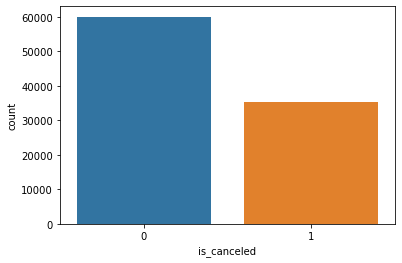

In [8]:
# countplot to see if is_canceled has balanced class distribution
sns.countplot(x='is_canceled', data=df_train)

This dataset has imbalance class.

#### Check if time of the year affects number of bookings

Text(0, 0.5, 'Number of booking')

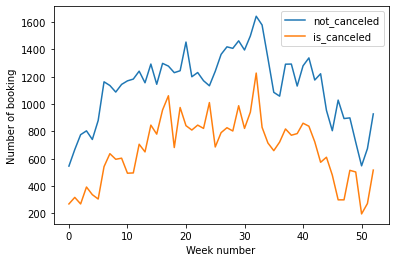

In [9]:
df_week_num_cancellation = df_train.groupby(['arrival_date_week_number', 'is_canceled']).count()
df_week_num_cancellation = df_week_num_cancellation.pivot_table(values='hotel', index='arrival_date_week_number', columns='is_canceled', fill_value=0)
df_week_num_cancellation = df_week_num_cancellation.reset_index().rename(columns={0: 'not_canceled', 1: 'is_canceled'})

sns.lineplot(x=df_week_num_cancellation.index, y='not_canceled', data=df_week_num_cancellation, label='not_canceled')
sns.lineplot(x=df_week_num_cancellation.index, y='is_canceled', data=df_week_num_cancellation, label='is_canceled')

plt.xlabel('Week number')
plt.ylabel('Number of booking')

Based on line plot above, it is clear that number of booking is higher in the middle of the year

#### Calculate financial loss from canceled bookings

ADR (Average Daily Rate) is the average price of room sold to guest on a given day.

In [10]:
avg_adr = df_train['adr'].mean()

print('Hotel ADR: EUR', round(avg_adr))

Hotel ADR: EUR 102


In [11]:
# calculate loss from canceled bookings
financial_loss = df_train[df_train['is_canceled'] == 1]['hotel'].count() * avg_adr

print('Total Loss (2015-2017): EUR {:,}'.format(round(financial_loss)))
print('Average Yearly Loss: EUR {:,}'.format(round((financial_loss/114)*52)))

Total Loss (2015-2017): EUR 3,600,088
Average Yearly Loss: EUR 1,642,145


### Analyse each numerical and categorical features

#### Define numerical and categorical feature to be analysed

In [12]:
num_cols = ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
ctg_cols = ['hotel', 'is_canceled', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'reservation_status']

Note that we don't use some features
- arrival_date_year
- arrival_date_day_of_month
- company

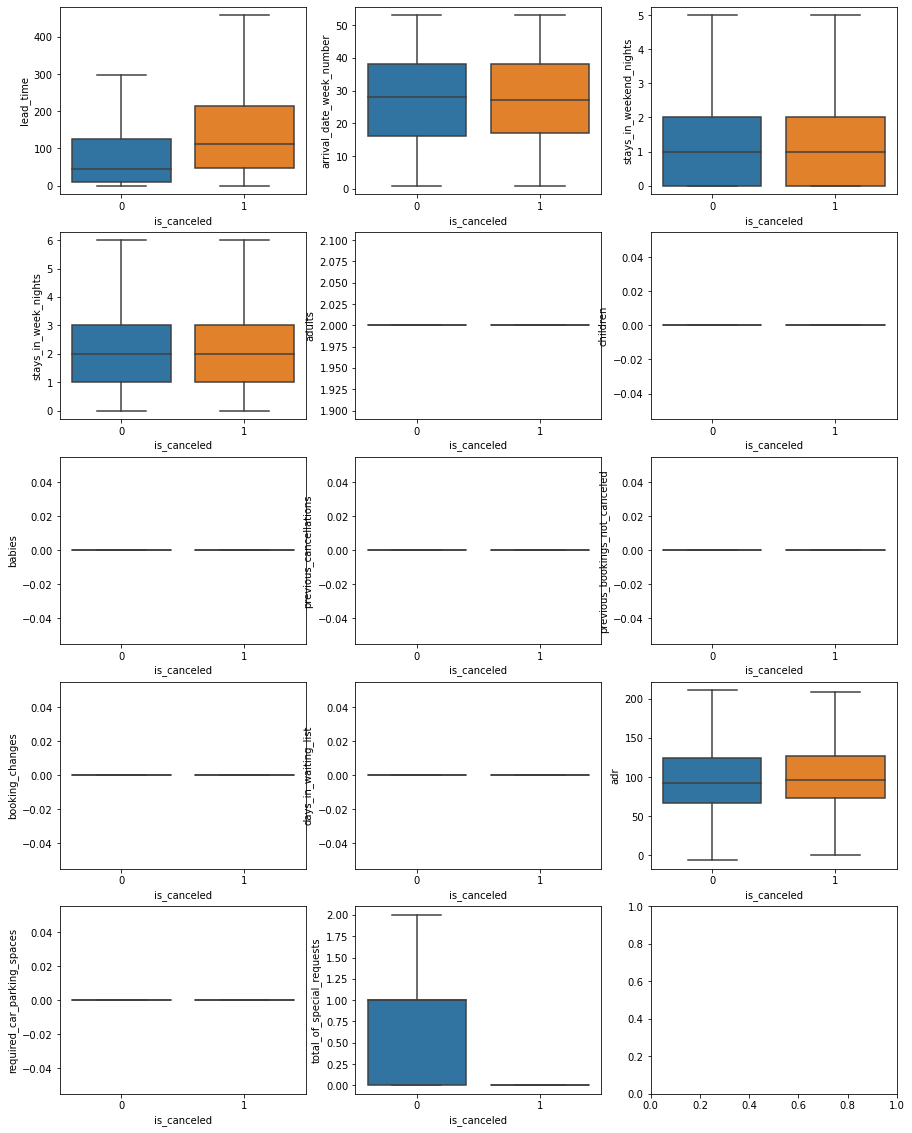

In [13]:
# plot numerical features
fig, ax = plt.subplots(5, 3, figsize=(15,20))

for ix, col in enumerate(num_cols):
    sns.boxplot(y=col, x='is_canceled', data=df_train, ax=ax.flatten()[ix], showfliers=False)

plt.show()

Based on boxplot above, only lead_time and total_of_special_requests features have noticeable difference between canceled and not-canceled.

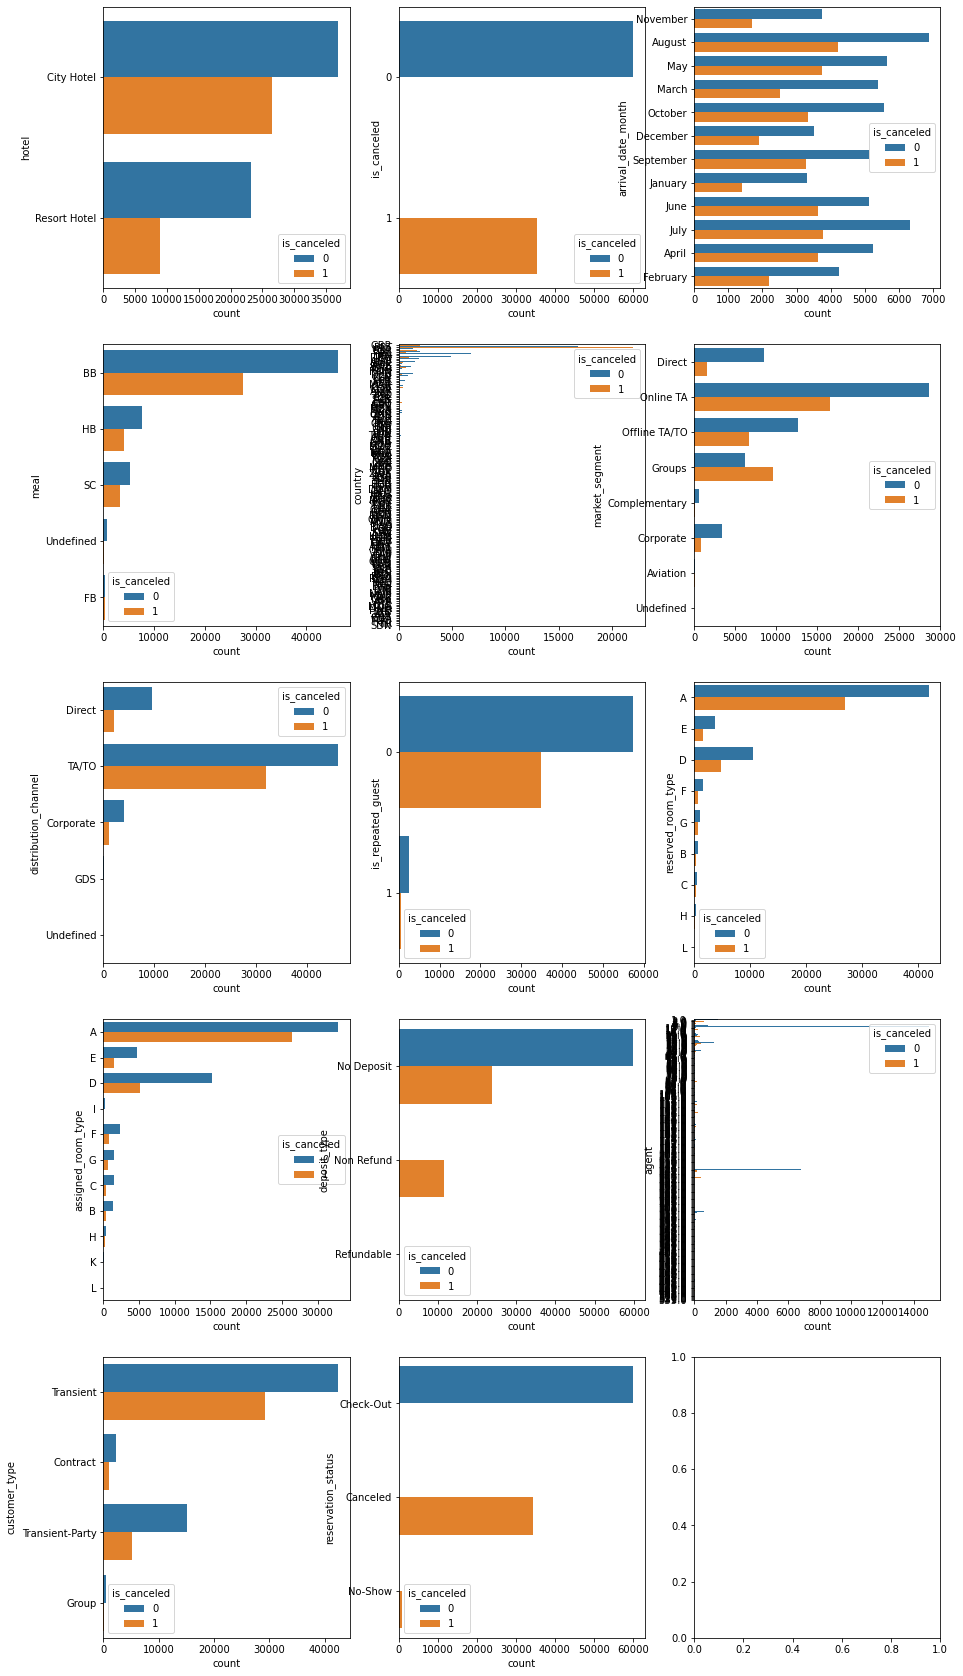

In [14]:
# plot categorical features
fig, ax = plt.subplots(5, 3, figsize=(15,30))

for ix, col in enumerate(ctg_cols):
    sns.countplot(y=col, hue='is_canceled', data=df_train, ax=ax.flatten()[ix])

plt.show()

based on countplots above, these are the features that might be used because they have big differences in some of the categories:
- hotel
- meal
- country (need further analysis because the plot isn't readable but shows some extreme values)
- market_segment
- distribution_channel
- reserved_room_type
- deposit_type
- customer_type
- is_repeated_guest

#### Further analysis on country feature

In [15]:
# count total bookings from each country, and their cancelation rate
df_country = df_train.groupby(['is_canceled', 'country']).count()
df_country = df_country.pivot_table(values='hotel', index='country', columns='is_canceled', fill_value=0)
df_country = df_country.rename(columns={0: 'not_canceled', 1: 'is_canceled'})
df_country['total_bookings'] = df_country['not_canceled'] + df_country['is_canceled']
df_country['cancel_rate'] = df_country['is_canceled'] / df_country['total_bookings']
df_country[df_country['cancel_rate'] < 1].sort_values(['total_bookings', 'cancel_rate'], ascending=False).head()

is_canceled,not_canceled,is_canceled,total_bookings,cancel_rate
country,,,,
PRT,16796,22007,38803,0.567147
GBR,7724,1976,9700,0.203711
FRA,6777,1546,8323,0.185750
ESP,5110,1728,6838,0.252705
DEU,4873,973,5846,0.166439


Based on the table above, we can see PRT has the highest number of bookings, but more than half of them is canceled.

### Explore the room types feature

#### Check for available room type

In [16]:
# room type reserved by guest
df_train['reserved_room_type'].unique()

array(['A', 'E', 'D', 'F', 'G', 'B', 'C', 'H', 'L'], dtype=object)

In [17]:
# room type assigned by hotel
df_train['assigned_room_type'].unique()

array(['A', 'E', 'D', 'I', 'F', 'G', 'C', 'B', 'H', 'K', 'L'],
      dtype=object)

There are 2 room types that are not available in reserved_room_type (type 'I' and 'K').

#### Check each room's price distribution

<AxesSubplot:xlabel='reserved_room_type', ylabel='adr'>

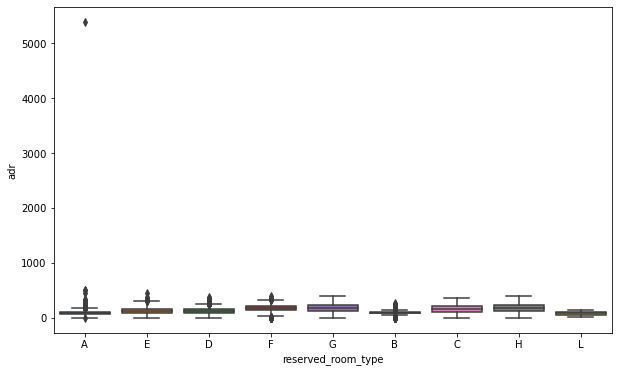

In [18]:
# plot the distribution of each room type ADR
plt.figure(figsize=(10,6))
sns.boxplot(x='reserved_room_type', y='adr', data=df_train)

Room type A has 1 extreme outlier. We will remove this data.

In [19]:
df_train[df_train['adr'] > 5000].index[0]

48515

In [20]:
df_train.drop(index=48515, inplace=True)

<AxesSubplot:xlabel='reserved_room_type', ylabel='adr'>

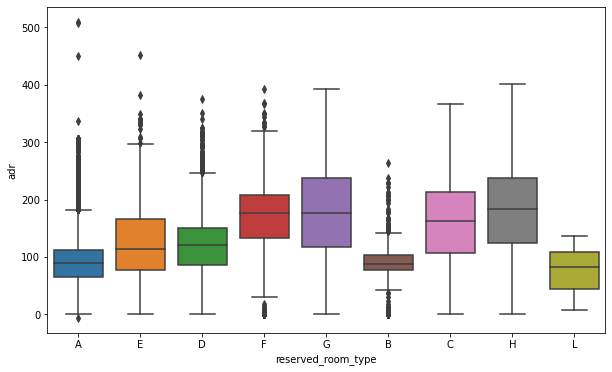

In [21]:
# plot the distribution of each room type ADR after removing extreme outlier
plt.figure(figsize=(10,6))
sns.boxplot(x='reserved_room_type', y='adr', data=df_train)

Each room type has different ADR distribution.

#### Rank each reserved room type based on their average ADR

Assumption: ADR is the price of reserved_room_type (the price at the time when guest booked the hotel), not the price of assigned_room_type (room assigned by the hotel).

We will calculate the average price of each room type based on reserved_room_type to find out which room type is more expensive.

Based of assumption above, we can't calculate the average price of room type 'I' and 'K' because there are no bookings with those reserved room type.

In [22]:
# calculate average ADR for each room type
df_mean_adr = pd.DataFrame(df_train.groupby('reserved_room_type')['adr'].mean().sort_values()).reset_index().rename(columns={'reserved_room_type': 'room_type'})
df_mean_adr

,room_type,adr
0,L,75.333333
1,B,90.197643
2,A,90.854180
3,D,120.765036
4,E,124.267114
5,C,160.144179
6,F,167.812154
7,G,175.808208
8,H,187.078241


We create a dictionary of room types and ranks pair to rank every booked and assigned room types. 

In [23]:
# create a room type ranking dictionary
room_type_rank_dict = {}

for room_type in df_mean_adr['room_type']:
    ix = df_mean_adr[df_mean_adr['room_type'] == room_type].index
    room_type_rank_dict[room_type] = ix[0]
    
room_type_rank_dict

{'L': 0, 'B': 1, 'A': 2, 'D': 3, 'E': 4, 'C': 5, 'F': 6, 'G': 7, 'H': 8}

We will give each booking's room a rank based on the dictionary

In [24]:
# select only the reserved and assigned room type of each bookings
df_reserved_assigned_room_pair = df_train[['reserved_room_type', 'assigned_room_type']]
df_reserved_assigned_room_pair

,reserved_room_type,assigned_room_type
101250,A,A
41642,A,A
89106,A,A
89379,E,E
108447,A,A
...,...,...
88641,A,A
24939,E,F
31687,D,D
95108,D,D


In [25]:
# create a function to encode each room's rank based on room_type_rank_dict.
# For room type 'I' and 'K', we will give them a different value.
def room_type_ranker(room_type):
    if (room_type in room_type_rank_dict):
        return room_type_rank_dict[room_type]
    else:
        # for room type 'I' and 'K'
        return len(room_type_rank_dict)

In [26]:
# applying the room_type_ranker function
df_reserved_assigned_room_pair['reserved_room_type_rank'] = df_reserved_assigned_room_pair['reserved_room_type'].apply(room_type_ranker)
df_reserved_assigned_room_pair['assigned_room_type_rank'] = df_reserved_assigned_room_pair['assigned_room_type'].apply(room_type_ranker)
df_reserved_assigned_room_pair

<ipython-input-26-ffc0d5147fef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reserved_assigned_room_pair['reserved_room_type_rank'] = df_reserved_assigned_room_pair['reserved_room_type'].apply(room_type_ranker)
<ipython-input-26-ffc0d5147fef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reserved_assigned_room_pair['assigned_room_type_rank'] = df_reserved_assigned_room_pair['assigned_room_type'].apply(room_type_ranker)


,reserved_room_type,assigned_room_type,reserved_room_type_rank,assigned_room_type_rank
101250,A,A,2,2
41642,A,A,2,2
89106,A,A,2,2
89379,E,E,4,4
108447,A,A,2,2
...,...,...,...,...
88641,A,A,2,2
24939,E,F,4,6
31687,D,D,3,3
95108,D,D,3,3


We will calculate the financial loss suffered by the hotel if they assigned a guest to a higher ranked room.

In [27]:
# select only bookings with different reserved and assigned room, and exclude room type 'I' and 'K'.
df_different_room_type = df_reserved_assigned_room_pair[
    (df_reserved_assigned_room_pair['reserved_room_type'] != df_reserved_assigned_room_pair['assigned_room_type']) &
    (df_reserved_assigned_room_pair['assigned_room_type_rank'] != 9)]
df_different_room_type

,reserved_room_type,assigned_room_type,reserved_room_type_rank,assigned_room_type_rank
2479,A,D,2,3
44049,A,D,2,3
82611,A,D,2,3
21701,A,D,2,3
18480,A,D,2,3
...,...,...,...,...
29941,A,D,2,3
43751,A,D,2,3
105120,A,D,2,3
20978,A,E,2,4


In [28]:
# select bookings with higher assigned room's rank than reserved room's rank
df_higher_room_assigned = pd.DataFrame(df_different_room_type[df_different_room_type['assigned_room_type_rank'] > df_different_room_type['reserved_room_type_rank']].groupby(['reserved_room_type', 'assigned_room_type']).count()['reserved_room_type_rank'].reset_index().rename(columns={'reserved_room_type_rank': 'count'}))

# insert price for each reserved and assigned room type
df_higher_room_assigned = df_higher_room_assigned.merge(right=df_mean_adr, how='inner', left_on='reserved_room_type', right_on='room_type')
df_higher_room_assigned = df_higher_room_assigned.merge(right=df_mean_adr, how='inner', left_on='assigned_room_type', right_on='room_type')
df_higher_room_assigned.drop(columns=['room_type_x', 'room_type_y'], inplace=True)
df_higher_room_assigned.rename(columns={'adr_x': 'reserved_room_price', 'adr_y': 'assigned_room_price'}, inplace=True)

# calculate loss from assigning higher room type to a booking with cheaper reserved room
df_higher_room_assigned['price_diff'] = df_higher_room_assigned['assigned_room_price'] - df_higher_room_assigned['reserved_room_price']
df_higher_room_assigned['total_price_diff'] = df_higher_room_assigned['price_diff'] * df_higher_room_assigned['count']
df_higher_room_assigned.sort_values(by=['reserved_room_type', 'assigned_room_type'])

,reserved_room_type,assigned_room_type,count,reserved_room_price,assigned_room_price,price_diff,total_price_diff
0,A,C,1162,90.854180,160.144179,69.289999,80514.978696
4,A,D,6069,90.854180,120.765036,29.910856,181528.986694
6,A,E,932,90.854180,124.267114,33.412934,31140.854888
9,A,F,339,90.854180,167.812154,76.957974,26088.753057
14,A,G,156,90.854180,175.808208,84.954028,13252.828389
20,A,H,78,90.854180,187.078241,96.224061,7505.476780
26,B,A,99,90.197643,90.854180,0.656537,64.997211
5,B,D,4,90.197643,120.765036,30.567394,122.269575
7,B,E,1,90.197643,124.267114,34.069472,34.069472
10,B,F,1,90.197643,167.812154,77.614511,77.614511


In [29]:
# calculate overall loss and average loss per booking
total_loss = round(df_higher_room_assigned['total_price_diff'].sum())
avg_loss = round(df_higher_room_assigned['total_price_diff'].sum()/df_higher_room_assigned['count'].sum())

print('Financial loss from assigning higher room type than reserved room type')
print('Total loss: EUR {:,}'.format(total_loss))
print('Average loss per room: EUR {:,}'.format(avg_loss))

Financial loss from assigning higher room type than reserved room type
Total loss: EUR 375,980
Average loss per room: EUR 37


In [30]:
df_train[df_train['is_canceled'] == 1].groupby('deposit_type').count()['hotel']

deposit_type
No Deposit    23764
Non Refund    11526
Refundable       29
Name: hotel, dtype: int64

#### Check for correlation coefficient from each numerical features to the target is_canceled

In [31]:
corr_coef = df_train.corr()
abs(corr_coef['is_canceled']).sort_values(ascending=False).head(6)

is_canceled                    1.000000
lead_time                      0.290579
total_of_special_requests      0.234161
required_car_parking_spaces    0.195163
booking_changes                0.146888
previous_cancellations         0.110142
Name: is_canceled, dtype: float64

From the heatmap above, 5 features with strongest correlation coefficient toward is_canceled are:
- lead_time
- total_of_special_requests
- required_car_parking_spaces
- booking_changes
- previous_cancellation

### Features to be Used
Based on the analysis above, here are the features that will be used to train the machine learning model:
- lead_time
- arrival_date_week_number
- previous_cancellation
- booking_changes
- required_car_parking_spaces
- total_of_special_requests
- hotel
- meal
- country
- market_segment
- distribution_channel
- reserved_room_type
- deposit_type
- customer_type
- is_repeated_guest

### To-dos:

- divide meal into BB and Other
- divide country into PRT and Other
- divide market_segment into Online TA, Direct, Offline TA/TO, Groups, Corporate, and Other
- divide distribution_channel into TA/TO, Direct, Corporate, and Other
- divide reserved_room_type into A, D, E and Other
- resampling to balance classes

# Data Preprocessing

#### Define some functions to encode data

In [32]:
def meal_encoder(meal):
    if (meal != 'BB'):
        meal = 'Other'
    return meal

def country_encoder(country):
    if (country != 'PRT'):
        country = 'Other'
    return country

def market_segment_encoder(market_segment):
    if (market_segment == 'Complementary')  or (market_segment == 'Aviation') or (market_segment == 'Undefined'):
        market_segment = 'Other'
    return market_segment

def distribution_channel_encoder(distribution_channel):
    if (distribution_channel == 'GDS') or (distribution_channel == 'Undefined'):
        distribution_channel = 'Other'
    return distribution_channel

def reserved_room_encoder(reserved_room_type):
    if (reserved_room_type != 'A') and (reserved_room_type != 'D') and (reserved_room_type != 'E'):
        reserved_room_type = 'Other'
    return reserved_room_type

In [33]:
df_train['meal_encoded'] = df_train['meal'].apply(meal_encoder)
df_test['meal_encoded'] = df_test['meal'].apply(meal_encoder)

df_train['country_encoded'] = df_train['country'].apply(country_encoder)
df_test['country_encoded'] = df_test['country'].apply(country_encoder)

df_train['market_segment_encoded'] = df_train['market_segment'].apply(market_segment_encoder)
df_test['market_segment_encoded'] = df_test['market_segment'].apply(market_segment_encoder)

df_train['distribution_channel_encoded'] = df_train['distribution_channel'].apply(distribution_channel_encoder)
df_test['distribution_channel_encoded'] = df_test['distribution_channel'].apply(distribution_channel_encoder)

df_train['reserved_room_type_encoded'] = df_train['reserved_room_type'].apply(reserved_room_encoder)
df_test['reserved_room_type_encoded'] = df_test['reserved_room_type'].apply(reserved_room_encoder)

In [34]:
# define columns to be used
used_num_cols = ['lead_time', 'arrival_date_week_number', 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests']
used_ctg_cols_encoded = ['hotel', 'meal_encoded', 'country_encoded', 'market_segment_encoded', 'distribution_channel_encoded', 'reserved_room_type_encoded', 'deposit_type', 'customer_type', 'is_repeated_guest']

In [35]:
# define OneHotEncoder to encode categorical columns
onehot_encoder = OneHotEncoder()
# define empty FunctionTransformer for numerical columns
do_nothing = FunctionTransformer()
# combine OneHotEncoder and FunctionTransformer in ColumnTransformer to be used in pipeline
col_transformer = ColumnTransformer([
    ('encoder', onehot_encoder, used_ctg_cols_encoded),
    ('do_nothing', do_nothing, used_num_cols)
])

In [36]:
# define feature and target dataset
X_train = df_train[used_num_cols + used_ctg_cols_encoded]
X_test = df_test[used_num_cols + used_ctg_cols_encoded]
y_train = df_train['is_canceled']
y_test = df_test['is_canceled']

In [37]:
# resampling to balance class with SMOTENC
smotenc = SMOTENC(random_state=22, categorical_features=range(6,15))
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

# Model Training

#### Create a function to run model fitting and calculate model performances.

In [38]:
# define a dataframe to store model's performance
df_model_score = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

In [39]:
def model_eval(estimator, estimator_name, train_feature, train_target, test_feature, test_target):
    # create empty list to store metrics, this will be used to compare the performance of each model
    metric_val = []
    
    # append model's name to metric_val
    metric_val.append(estimator_name)
    
    # fit train set to model
    estimator.fit(train_feature, train_target)
    
    # define metrics to be used for calculating cross validation score
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # calculate metrics with cross validation
    for metric in metrics:
        val = cross_val_score(estimator, train_feature, train_target, scoring=metric, cv=5).mean()
        # append cross validation score to metric_val
        metric_val.append(val)
    
    # predict test set
    y_pred = estimator.predict(test_feature)

    # calculate accuracy, confision matrix, and classification report
    acc = accuracy_score(test_target, y_pred)
    conf = confusion_matrix(test_target, y_pred)
    clf_report = classification_report(test_target, y_pred)
    
    print(f"Accuracy Score : {acc}")
    print(f"Confusion Matrix : \n{conf}")
    print(f"Classification Report : \n{clf_report}")
    
    # predict probability of test set for ROC-AUC
    y_pred_proba = estimator.predict_proba(test_feature)[::,1]
    
    # calculate FPR and TPR for ROC
    fpr, tpr, _ = roc_curve(test_target,  y_pred_proba)
    # calculate AUC
    auc = roc_auc_score(test_target, y_pred_proba)
    
    #create ROC curve
    plt.title('ROC AUC')
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    # append AUC score
    metric_val.append(auc)
    
    # append cross validation score to df_model_score
    df_len = len(df_model_score)
    df_model_score.loc[df_len] = metric_val

## Base Model

#### Logistic Regression

Accuracy Score : 0.7956127841624024
Confusion Matrix : 
[[12293  2670]
 [ 2203  6676]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.82      0.83     14963
           1       0.71      0.75      0.73      8879

    accuracy                           0.80     23842
   macro avg       0.78      0.79      0.78     23842
weighted avg       0.80      0.80      0.80     23842



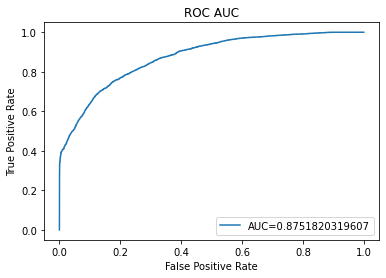

In [40]:
log_reg = LogisticRegression(max_iter=3000)

log_reg_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('log_reg', log_reg)
])

model_eval(log_reg_pipeline, 'Logistic Regression', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### KNN

Accuracy Score : 0.7865531415149736
Confusion Matrix : 
[[11794  3169]
 [ 1920  6959]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.79      0.82     14963
           1       0.69      0.78      0.73      8879

    accuracy                           0.79     23842
   macro avg       0.77      0.79      0.78     23842
weighted avg       0.80      0.79      0.79     23842



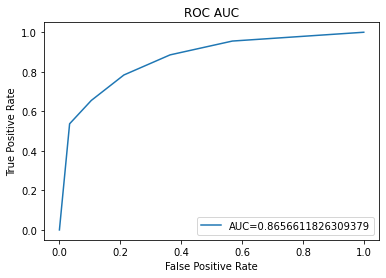

In [41]:
knn = KNeighborsClassifier()

knn_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('knn', knn)
])

model_eval(knn_pipeline, 'KNN', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### Decision Tree

Accuracy Score : 0.8320610687022901
Confusion Matrix : 
[[12776  2187]
 [ 1817  7062]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     14963
           1       0.76      0.80      0.78      8879

    accuracy                           0.83     23842
   macro avg       0.82      0.82      0.82     23842
weighted avg       0.83      0.83      0.83     23842



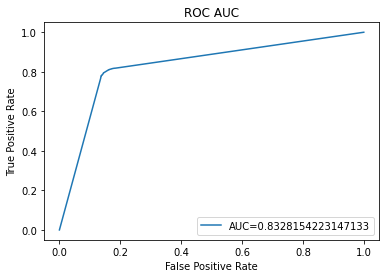

In [42]:
dt = DecisionTreeClassifier(random_state=22, class_weight='balanced')

dt_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('dt', dt)
])

model_eval(dt_pipeline, 'Decision Tree', X_train_smotenc, y_train_smotenc, X_test, y_test)

In [43]:
df_model_score.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1,AUC
2,Decision Tree,0.848729,0.843752,0.856130,0.849031,0.832815
1,KNN,0.823450,0.795697,0.869653,0.830533,0.865661
0,Logistic Regression,0.794398,0.807673,0.772614,0.789404,0.875182


## Base Model Hyperparameter Tuning

### Grid Search

#### Decision Tree

In [44]:
dt_param_grid = {
    'dt__criterion': ['entropy'],
    'dt__max_depth': [50],
    'dt__min_samples_split': [2]
}

dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid
)

dt_grid_search.fit(X_train_smotenc, y_train_smotenc)

GridSearchCV(estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(),
                                                                         ['hotel',
                                                                          'meal_encoded',
                                                                          'country_encoded',
                                                                          'market_segment_encoded',
                                                                          'distribution_channel_encoded',
                                                                          'reserved_room_type_encoded',
                                                                          'deposit_type',
                                                                          'customer_type',
          

In [45]:
pd.DataFrame(dt_grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.094408,0.094349,0.101488,0.009167,entropy,50,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.83189,0.832424,0.83105,0.872892,0.875848,0.848821,0.020886,1


Accuracy Score : 0.8324385538125996
Confusion Matrix : 
[[12800  2163]
 [ 1832  7047]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     14963
           1       0.77      0.79      0.78      8879

    accuracy                           0.83     23842
   macro avg       0.82      0.82      0.82     23842
weighted avg       0.83      0.83      0.83     23842



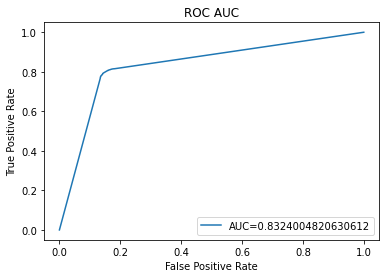

In [46]:
dt_best = dt_grid_search.best_estimator_

model_eval(dt_best, 'Best Decision Tree', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### KNN

In [47]:
knn_param_grid = {
    'knn__n_neighbors': [5],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['ball_tree', 'kd_tree']
}

knn_grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid
)

knn_grid_search.fit(X_train_smotenc, y_train_smotenc)

GridSearchCV(estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(),
                                                                         ['hotel',
                                                                          'meal_encoded',
                                                                          'country_encoded',
                                                                          'market_segment_encoded',
                                                                          'distribution_channel_encoded',
                                                                          'reserved_room_type_encoded',
                                                                          'deposit_type',
                                                                          'customer_type',
          

In [48]:
pd.DataFrame(knn_grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.823535,0.076333,5.784767,0.245500,ball_tree,5,distance,"{'knn__algorithm': 'ball_tree', 'knn__n_neighb...",0.818818,0.818644,0.820642,0.866772,0.865815,0.838138,0.023001,1
3,2.963030,0.044620,2.623670,0.122144,kd_tree,5,distance,"{'knn__algorithm': 'kd_tree', 'knn__n_neighbor...",0.818193,0.818519,0.821308,0.866689,0.864066,0.837755,0.022595,2
0,1.884923,0.175385,6.468398,0.220125,ball_tree,5,uniform,"{'knn__algorithm': 'ball_tree', 'knn__n_neighb...",0.806411,0.805571,0.806611,0.855656,0.854865,0.825823,0.024040,3
2,3.026628,0.077610,3.586654,0.137739,kd_tree,5,uniform,"{'knn__algorithm': 'kd_tree', 'knn__n_neighbor...",0.805912,0.804488,0.806778,0.855448,0.852950,0.825115,0.023771,4


Accuracy Score : 0.8086989346531331
Confusion Matrix : 
[[12339  2624]
 [ 1937  6942]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     14963
           1       0.73      0.78      0.75      8879

    accuracy                           0.81     23842
   macro avg       0.80      0.80      0.80     23842
weighted avg       0.81      0.81      0.81     23842



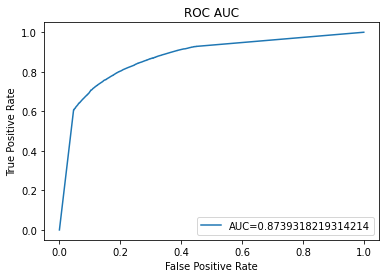

In [49]:
knn_best = knn_grid_search.best_estimator_
model_eval(knn_best, 'Best KNN', X_train_smotenc, y_train_smotenc, X_test, y_test)

## Ensemble Model

#### Random Forest

Accuracy Score : 0.8464893884741213
Confusion Matrix : 
[[12979  1984]
 [ 1676  7203]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     14963
           1       0.78      0.81      0.80      8879

    accuracy                           0.85     23842
   macro avg       0.83      0.84      0.84     23842
weighted avg       0.85      0.85      0.85     23842



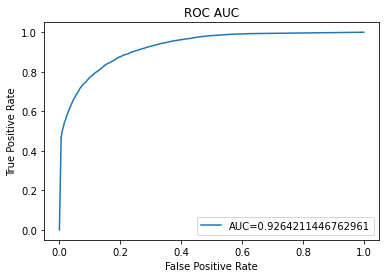

In [50]:
rf = RandomForestClassifier(random_state=22)

rf_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('rf', rf)
])

model_eval(rf_pipeline, 'Random Forest', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### XGBoost

Accuracy Score : 0.8438469927019545
Confusion Matrix : 
[[12939  2024]
 [ 1699  7180]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     14963
           1       0.78      0.81      0.79      8879

    accuracy                           0.84     23842
   macro avg       0.83      0.84      0.83     23842
weighted avg       0.85      0.84      0.84     23842



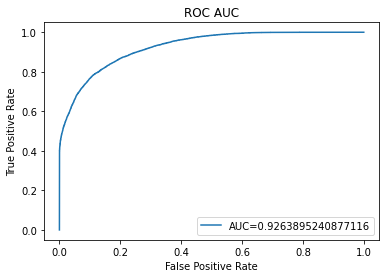

In [51]:
xgb = XGBClassifier()

xgb_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('xgb', xgb)
])

model_eval(xgb_pipeline, 'XGBoost', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### Light Gradient Boosting Machine

Accuracy Score : 0.8407851690294439
Confusion Matrix : 
[[12969  1994]
 [ 1802  7077]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     14963
           1       0.78      0.80      0.79      8879

    accuracy                           0.84     23842
   macro avg       0.83      0.83      0.83     23842
weighted avg       0.84      0.84      0.84     23842



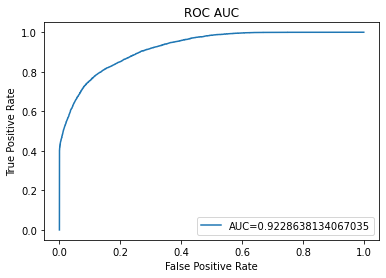

In [52]:
lgbm = LGBMClassifier()

lgbm_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('lgbm', lgbm)
])

model_eval(lgbm_pipeline, 'Light GBM', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### Catboost

Accuracy Score : 0.8446019629225736
Confusion Matrix : 
[[12910  2053]
 [ 1652  7227]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     14963
           1       0.78      0.81      0.80      8879

    accuracy                           0.84     23842
   macro avg       0.83      0.84      0.84     23842
weighted avg       0.85      0.84      0.85     23842



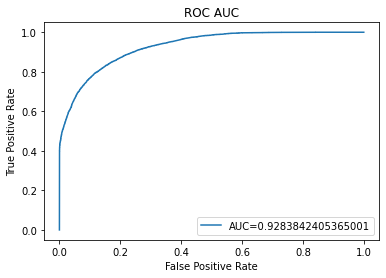

In [53]:
cb = CatBoostClassifier(logging_level='Silent')

cb_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('cb', cb)
])

model_eval(cb_pipeline, 'Catboost', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### Adaboost

Accuracy Score : 0.813690126667226
Confusion Matrix : 
[[12726  2237]
 [ 2205  6674]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14963
           1       0.75      0.75      0.75      8879

    accuracy                           0.81     23842
   macro avg       0.80      0.80      0.80     23842
weighted avg       0.81      0.81      0.81     23842



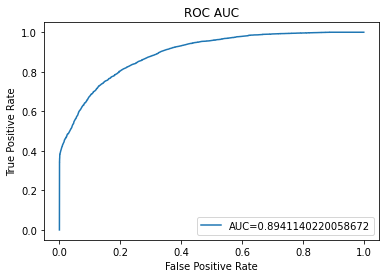

In [54]:
ab = AdaBoostClassifier()

ab_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('ab', ab)
])

model_eval(ab_pipeline, 'Adaboost', X_train_smotenc, y_train_smotenc, X_test, y_test)

#### Voting

Accuracy Score : 0.8404915694992031
Confusion Matrix : 
[[12915  2048]
 [ 1755  7124]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     14963
           1       0.78      0.80      0.79      8879

    accuracy                           0.84     23842
   macro avg       0.83      0.83      0.83     23842
weighted avg       0.84      0.84      0.84     23842



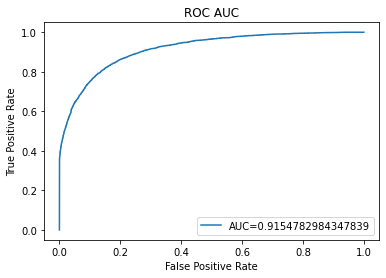

In [55]:
voting = VotingClassifier(estimators=[('lr', log_reg), ('knn', knn), ('dt', dt)], voting='soft')

voting_pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('voting', voting)
])

model_eval(voting_pipeline, 'Voting Classifier', X_train_smotenc, y_train_smotenc, X_test, y_test)

## Ensemble Model Hyperparameter Tuning

#### Random Forest

In [56]:
rf_param_grid = {
    'rf__n_estimators': [250],
    'rf__max_depth': [50],
    'rf__min_samples_split': [6]
}

rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid
)

rf_grid_search.fit(X_train_smotenc, y_train_smotenc)

GridSearchCV(estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(),
                                                                         ['hotel',
                                                                          'meal_encoded',
                                                                          'country_encoded',
                                                                          'market_segment_encoded',
                                                                          'distribution_channel_encoded',
                                                                          'reserved_room_type_encoded',
                                                                          'deposit_type',
                                                                          'customer_type',
          

In [57]:
pd.DataFrame(rf_grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,45.474606,1.064938,2.687908,0.061054,50,6,250,"{'rf__max_depth': 50, 'rf__min_samples_split':...",0.848626,0.848786,0.850535,0.892294,0.892585,0.866565,0.021137,1
23,33.713644,0.747232,2.350041,0.157081,100,6,250,"{'rf__max_depth': 100, 'rf__min_samples_split'...",0.848751,0.848953,0.850285,0.891919,0.892627,0.866507,0.021046,2
14,46.449168,2.934135,2.885229,0.220598,75,6,250,"{'rf__max_depth': 75, 'rf__min_samples_split':...",0.848751,0.848953,0.850285,0.891919,0.892627,0.866507,0.021046,2
21,20.013632,0.140006,1.465019,0.061243,100,6,150,"{'rf__max_depth': 100, 'rf__min_samples_split'...",0.848043,0.848661,0.850035,0.892335,0.892835,0.866382,0.021405,4
12,26.648229,0.788454,1.714276,0.049566,75,6,150,"{'rf__max_depth': 75, 'rf__min_samples_split':...",0.848043,0.848661,0.850035,0.892335,0.892835,0.866382,0.021405,4


Accuracy Score : 0.8509772670078014
Confusion Matrix : 
[[13123  1840]
 [ 1713  7166]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14963
           1       0.80      0.81      0.80      8879

    accuracy                           0.85     23842
   macro avg       0.84      0.84      0.84     23842
weighted avg       0.85      0.85      0.85     23842



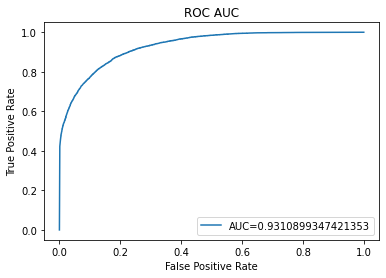

In [58]:
rf_best = rf_grid_search.best_estimator_
model_eval(rf_best, 'Best Random Forest', X_train_smotenc, y_train_smotenc, X_test, y_test)

In [67]:
df_model_score.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1,AUC
11,Best Random Forest,0.866565,0.873113,0.857812,0.864670,0.931090
5,Random Forest,0.865150,0.867720,0.861576,0.863997,0.926421
10,Voting Classifier,0.861261,0.857689,0.866072,0.861196,0.915478
8,Catboost,0.851785,0.861174,0.838695,0.849446,0.928384
3,Best Decision Tree,0.848821,0.844035,0.855897,0.849076,0.832400
2,Decision Tree,0.848729,0.843752,0.856130,0.849031,0.832815
6,XGBoost,0.849762,0.861632,0.833216,0.846905,0.926390
4,Best KNN,0.838138,0.821549,0.863508,0.841440,0.873932
7,Light GBM,0.843509,0.861238,0.818844,0.839241,0.922864
1,KNN,0.823450,0.795697,0.869653,0.830533,0.865661


In [61]:
df_model_score.sort_values(by='AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1,AUC
11,Best Random Forest,0.866565,0.873113,0.857812,0.864670,0.931090
8,Catboost,0.851785,0.861174,0.838695,0.849446,0.928384
5,Random Forest,0.865150,0.867720,0.861576,0.863997,0.926421
6,XGBoost,0.849762,0.861632,0.833216,0.846905,0.926390
7,Light GBM,0.843509,0.861238,0.818844,0.839241,0.922864
10,Voting Classifier,0.861261,0.857689,0.866072,0.861196,0.915478
9,Adaboost,0.810152,0.839211,0.767119,0.801335,0.894114
0,Logistic Regression,0.794398,0.807673,0.772614,0.789404,0.875182
4,Best KNN,0.838138,0.821549,0.863508,0.841440,0.873932
1,KNN,0.823450,0.795697,0.869653,0.830533,0.865661


In [62]:
df_model_score

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.794398,0.807673,0.772614,0.789404,0.875182
1,KNN,0.823450,0.795697,0.869653,0.830533,0.865661
2,Decision Tree,0.848729,0.843752,0.856130,0.849031,0.832815
3,Best Decision Tree,0.848821,0.844035,0.855897,0.849076,0.832400
4,Best KNN,0.838138,0.821549,0.863508,0.841440,0.873932
5,Random Forest,0.865150,0.867720,0.861576,0.863997,0.926421
6,XGBoost,0.849762,0.861632,0.833216,0.846905,0.926390
7,Light GBM,0.843509,0.861238,0.818844,0.839241,0.922864
8,Catboost,0.851785,0.861174,0.838695,0.849446,0.928384
9,Adaboost,0.810152,0.839211,0.767119,0.801335,0.894114
